In [2]:
import pandas as pd
import numpy as np
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
import sqlite3
from datetime import datetime
%matplotlib inline

In [3]:
# Télécharger les ressources NLTK
nltk.download('punkt')
nltk.download('stopwords')
stop_words = set(stopwords.words('english'))

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\guilb\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping tokenizers\punkt.zip.
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\guilb\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping corpora\stopwords.zip.


In [4]:
# Charger les données
emails = pd.read_csv('C:/Users/guilb/Documents/CV/skills/Phishing_Email_Dataset/data/cleaned_emails.csv')

In [5]:
# Exploration initiale
print("Aperçu des données :")
print(emails.head())
print("\nInformations :")
print(emails.info())
print("\nRépartition des classes :")
print(emails['is_phishing'].value_counts())  # 11322 phishing, 7328 non-phishing
print("\nStatistiques de text_length :")
print(emails['text_length'].describe())

Aperçu des données :
   email_id                                         email_text  is_phishing  \
0         1  re : 6 . 1100 , disc : uniformitarianism , re ...            0   
1         2  the other side of * galicismos * * galicismo *...            0   
2         3  re : equistar deal tickets are you still avail...            0   
3         4  \nHello I am your hot lil horny toy.\n    I am...            1   
4         5  software at incredibly low prices ( 86 % lower...            1   

   text_length  has_url  keyword_count  
0         1030      NaN              0  
1          479      NaN              0  
2         1245      NaN              0  
3          688      NaN              0  
4          441      NaN              0  

Informations :
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18650 entries, 0 to 18649
Data columns (total 6 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   email_id       18650 non-null  int64  
 1

In [8]:
# Identifier les outliers extrêmes
print("\nEmails avec text_length > 10000 :")
print(emails[emails['text_length'] > 10000][['email_id', 'text_length', 'is_phishing', 'email_text']].head())

#On peut voir que les outliers ne permettent pas d'identifier les mails spams par arpport aux mails non spam. 


Emails avec text_length > 10000 :
     email_id  text_length  is_phishing  \
367       368        10260            0   
379       380        18091            1   
452       453        16351            1   
466       467        16999            0   
502       503        12117            0   

                                            email_text  
367  sum : sign-singing a few weeks ago i posted th...  
379  ****************************\nNow Open Seven D...  
452  \nÂ \nFree Personal and Business Grants\nÂ " Q...  
466                    ___           ___           ...  
502  glow ' 99 call for papers : glow 1999 the glow...  


In [7]:
# Visualisations : Scatterplots et Boxplot
phishing_emails = emails[emails['is_phishing'] == 1]
no_phishing_emails = emails[emails['is_phishing'] == 0]

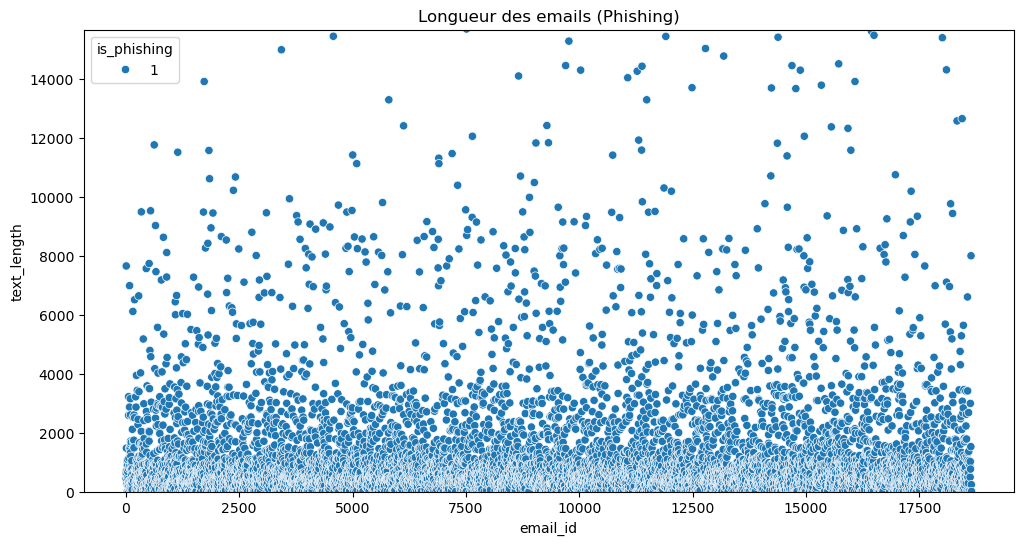

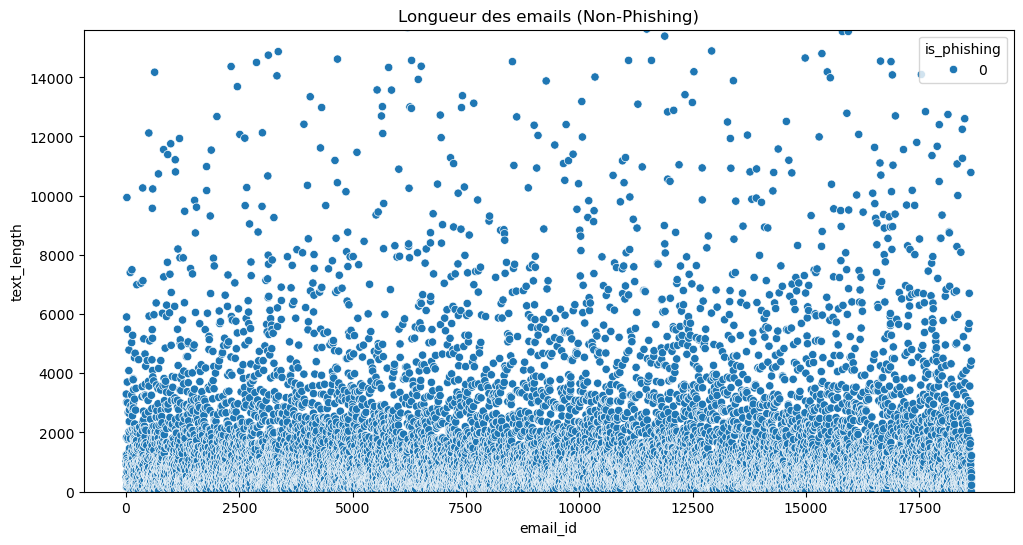

In [13]:
# Scatterplots avec la longueur des emais spams
plt.figure(figsize=(12, 6))
sns.scatterplot(x='email_id', y='text_length', hue='is_phishing', data=phishing_emails, sizes=(20, 200))
plt.ylim(0, phishing_emails['text_length'].quantile(0.99))  # Limite au 99e centile
plt.title("Longueur des emails (Phishing)")
plt.savefig('C:/Users/guilb/Documents/CV/skills/Phishing_Email_Dataset/python/text_length_scatterplot_phishing.png')
plt.show()


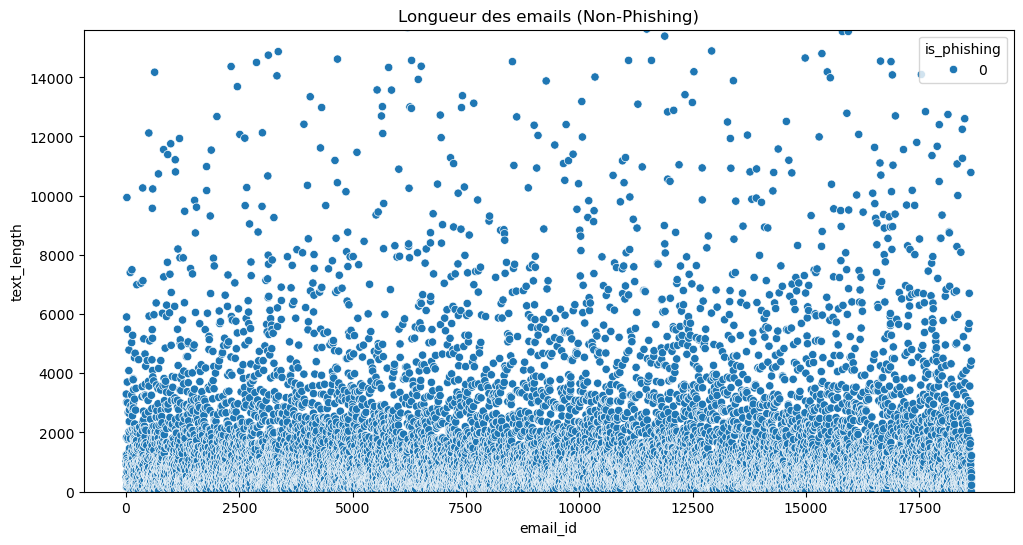

In [14]:
# Scatterplots avec la longueur des emais non-spams
plt.figure(figsize=(12, 6))
sns.scatterplot(x='email_id', y='text_length', hue='is_phishing', data=no_phishing_emails, sizes=(20, 200))
plt.ylim(0, no_phishing_emails['text_length'].quantile(0.99))
plt.title("Longueur des emails (Non-Phishing)")
plt.savefig('C:/Users/guilb/Documents/CV/skills/Phishing_Email_Dataset/python/text_length_scatterplot_no_phishing.png')
plt.show()

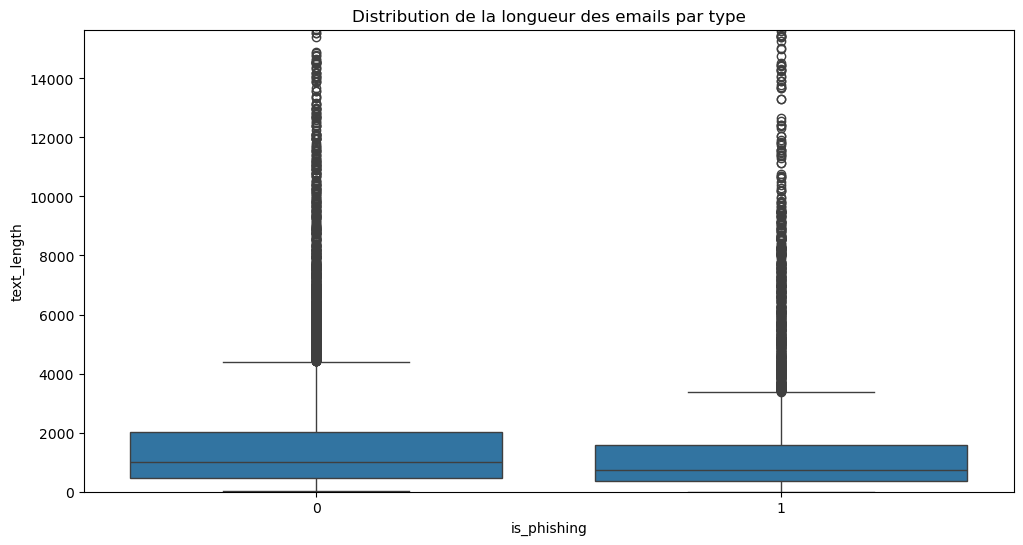

In [15]:
# Boxplot
plt.figure(figsize=(12, 6))
sns.boxplot(x='is_phishing', y='text_length', data=emails)
plt.ylim(0, emails['text_length'].quantile(0.99))
plt.title("Distribution de la longueur des emails par type")
plt.savefig('C:/Users/guilb/Documents/CV/skills/Phishing_Email_Dataset/python/text_length_boxplot.png')
plt.show()

# On s'aperçoit que la distribution des mais spams est beaucoup plus importante avec des longeurs très petites ou très grandes

In [16]:
# Détection des outliers avec IQR
Q1 = np.percentile(emails['text_length'], 25, method='midpoint')
Q3 = np.percentile(emails['text_length'], 75, method='midpoint')
IQR = Q3 - Q1
upper = Q3 + 1.5 * IQR
lower = max(0, Q1 - 1.5 * IQR)  # Pas de longueurs négatives

upper_array = emails['text_length'] >= upper
print("Upper Bound:", upper, "Nombre d'outliers supérieurs:", upper_array.sum())
lower_array = emails['text_length'] <= lower
print("Lower Bound:", lower, "Nombre d'outliers inférieurs:", lower_array.sum())


Upper Bound: 4094.25 Nombre d'outliers supérieurs: 1715
Lower Bound: 0 Nombre d'outliers inférieurs: 0


In [20]:
phishing_texts = emails[emails['is_phishing'] == 1]['email_text']
non_phishing_texts = emails[emails['is_phishing'] == 0]['email_text']
phishing_words = " ".join(phishing_texts)
non_phishing_words = " ".join(non_phishing_texts)

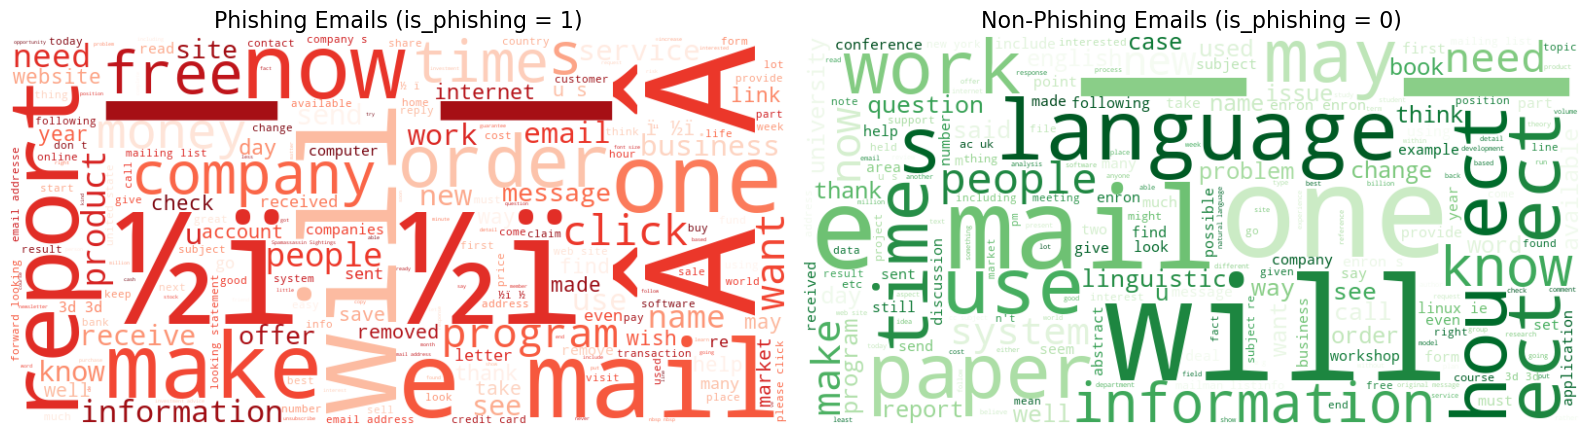

In [21]:
# Create WordCloud objects
phishing_wc = WordCloud(width=800, height=400, background_color='white', colormap='Reds').generate(phishing_words)
non_phishing_wc = WordCloud(width=800, height=400, background_color='white', colormap='Greens').generate(non_phishing_words)

# Plot
plt.figure(figsize=(16, 8))

plt.subplot(1, 2, 1)
plt.imshow(phishing_wc, interpolation='bilinear')
plt.axis('off')
plt.title('Phishing Emails (is_phishing = 1)', fontsize=16)

plt.subplot(1, 2, 2)
plt.imshow(non_phishing_wc, interpolation='bilinear')
plt.axis('off')
plt.title('Non-Phishing Emails (is_phishing = 0)', fontsize=16)

plt.tight_layout()
plt.show()

# On s'aperçoit que les mails spams utilisent de nombreux caratères spéciaux, ainsu=i qu'un langage accrocheur : free, need, order, will, now, make
# Pour les mails non spams, des terms se rapprochent tels que need, will, information mais aussi plus informatif tel que work, use, mail, question, how, paper

In [22]:
# J'exporte les fréquences de mots pour une future analyse de Power BI
phishing_word_freq = pd.Series(phishing_words.split()).value_counts().head(50)
non_phishing_word_freq = pd.Series(non_phishing_words.split()).value_counts().head(50)
phishing_word_freq.to_csv('C:/Users/guilb/Documents/CV/skills/Phishing_Email_Dataset/python/phishing_word_freq.csv', header=['frequency'])
non_phishing_word_freq.to_csv('C:/Users/guilb/Documents/CV/skills/Phishing_Email_Dataset/python/non_phishing_word_freq.csv', header=['frequency'])

In [24]:
stop_words = list(stopwords.words('english'))

In [25]:
# Vectorisation des textes
vectorizer = TfidfVectorizer(stop_words=stop_words, max_features=1000)
X = vectorizer.fit_transform(emails_cleaned['email_text'].fillna(''))  # Remplacer les NaN par une chaîne vide
y = emails_cleaned['is_phishing']

In [26]:
# Séparation des données
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [27]:
# Entraînement du modèle
model = LogisticRegression(max_iter=1000)  # Augmenter max_iter pour éviter les problèmes de convergence
model.fit(X_train, y_train)

LogisticRegression(max_iter=1000)

In [28]:
# Prédictions et évaluation
y_pred = model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)
class_report = classification_report(y_test, y_pred)

print("\nPrécision du modèle :", accuracy)
print("\nRapport de classification :\n", class_report)


Précision du modèle : 0.9523715803975595

Rapport de classification :
               precision    recall  f1-score   support

           0       0.97      0.95      0.96      3032
           1       0.93      0.95      0.94      2049

    accuracy                           0.95      5081
   macro avg       0.95      0.95      0.95      5081
weighted avg       0.95      0.95      0.95      5081



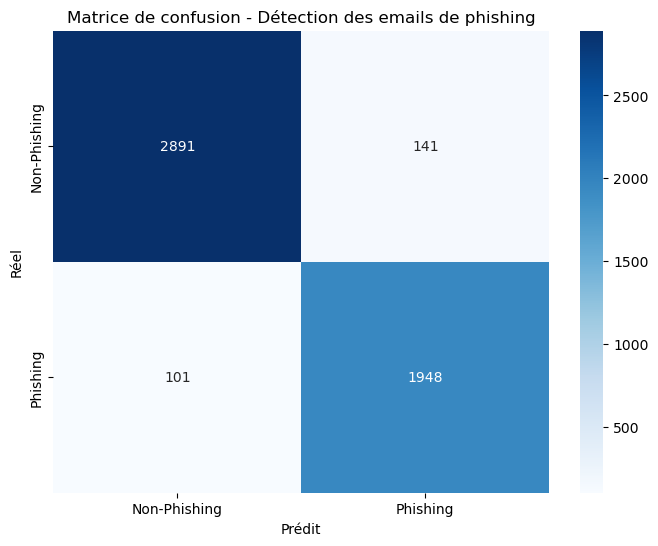

In [29]:
# Visualisation de la matrice de confusion
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Non-Phishing', 'Phishing'], yticklabels=['Non-Phishing', 'Phishing'])
plt.title("Matrice de confusion - Détection des emails de phishing")
plt.xlabel("Prédit")
plt.ylabel("Réel")
plt.savefig('C:/Users/guilb/Documents/CV/skills/Phishing_Email_Dataset/python/confusion_matrix.png')
plt.show()

In [30]:
# Interprétation des coefficients du modèle
feature_names = vectorizer.get_feature_names_out()
coefficients = model.coef_[0]
coef_df = pd.DataFrame({'Mot': feature_names, 'Coefficient': coefficients})
coef_df = coef_df.sort_values(by='Coefficient', ascending=False)

print("\nMots les plus associés aux emails de phishing (top 10) :")
print(coef_df.head(10))
print("\nMots les moins associés aux emails de phishing (top 10) :")
print(coef_df.tail(10))


Mots les plus associés aux emails de phishing (top 10) :
           Mot  Coefficient
32        2005     4.223439
731     remove     3.833229
185      click     3.826775
802  sightings     3.814258
31        2004     3.415984
565      money     3.413925
344       free     3.350143
957      watch     3.039279
810       site     2.865646
511        low     2.804762

Mots les moins associés aux emails de phishing (top 10) :
          Mot  Coefficient
126  attached    -3.176576
275       edu    -3.222954
29       2001    -3.285276
951     vince    -3.426576
461  language    -3.826040
885    thanks    -4.004961
30       2002    -4.503427
935       url    -4.750622
988     wrote    -5.144434
291     enron    -6.728359


C:\Users\guilb\AppData\Local\Temp\ipykernel_22384\548888271.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Coefficient', y='Mot', data=coef_df.head(10), palette='Reds')


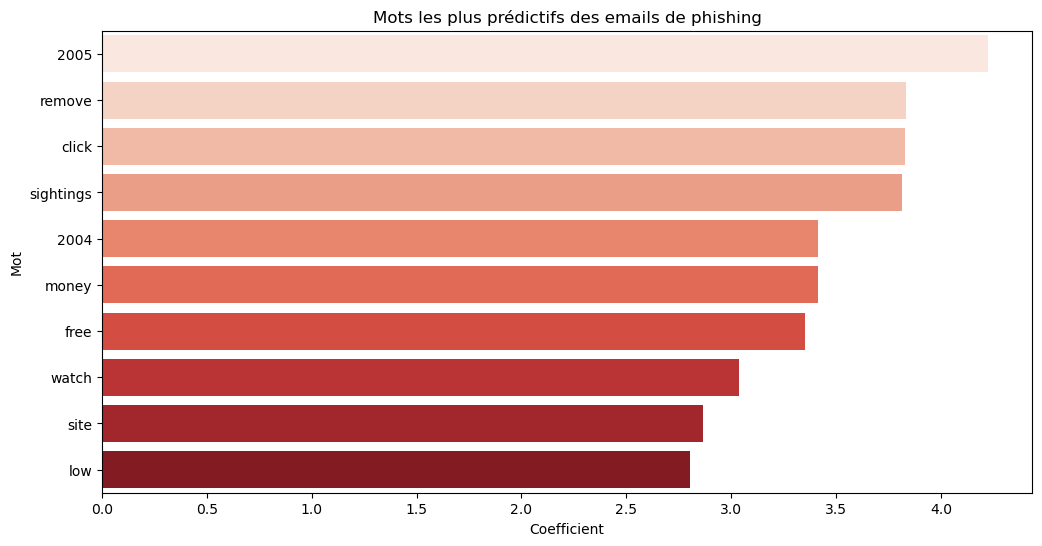

C:\Users\guilb\AppData\Local\Temp\ipykernel_22384\548888271.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Coefficient', y='Mot', data=coef_df.tail(10), palette='Greens')


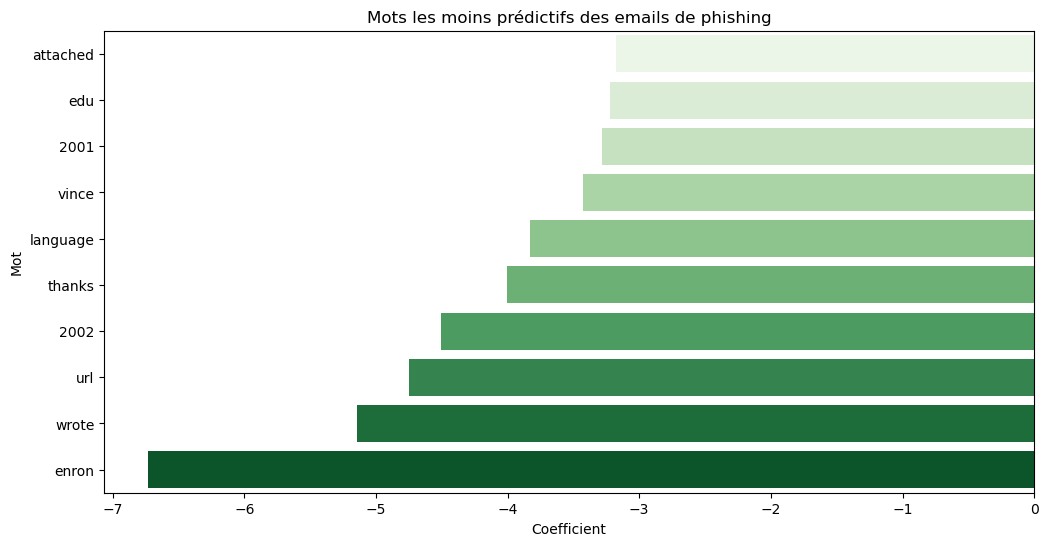

In [31]:
# Visualisation des coefficients
plt.figure(figsize=(12, 6))
sns.barplot(x='Coefficient', y='Mot', data=coef_df.head(10), palette='Reds')
plt.title("Mots les plus prédictifs des emails de phishing")
plt.savefig('C:/Users/guilb/Documents/CV/skills/Phishing_Email_Dataset/python/top_phishing_words.png')
plt.show()

plt.figure(figsize=(12, 6))
sns.barplot(x='Coefficient', y='Mot', data=coef_df.tail(10), palette='Greens')
plt.title("Mots les moins prédictifs des emails de phishing")
plt.savefig('C:/Users/guilb/Documents/CV/skills/Phishing_Email_Dataset/python/top_non_phishing_words.png')
plt.show()

In [32]:
# Exporter les résultats pour Power BI
coef_df.to_csv('C:/Users/guilb/Documents/CV/skills/Phishing_Email_Dataset/python/coefficient_analysis.csv', index=False)